In [1]:
import cv2
import numpy as np
import imutils
import os
import shutil
from matplotlib import pyplot as plt
from IPython.display import Image 
from PIL import Image        
from types import SimpleNamespace
import random as rng
rng.seed(12345)
from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
# to load images

In [2]:
file_ready_for_lines_detection = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/88d1c53a-4933-55ab-9223-3d14f4d87a07-e6722290_pg-0_sg-0_M.jpg")
# input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/b2432346-2637-5e69-a752-128f71c1bb44-1d8625b3_pg-0_sg-0.jpg")
input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/88d1c53a-4933-55ab-9223-3d14f4d87a07-e6722290_pg-0_sg-0_M.jpg")

In [76]:
# img = cv2.imread(file_ready_for_lines_detection)
img = cv2.imread(input_file)
orig_img = cv2.imread(input_file)
line_only_img = cv2.imread(file_ready_for_lines_detection)

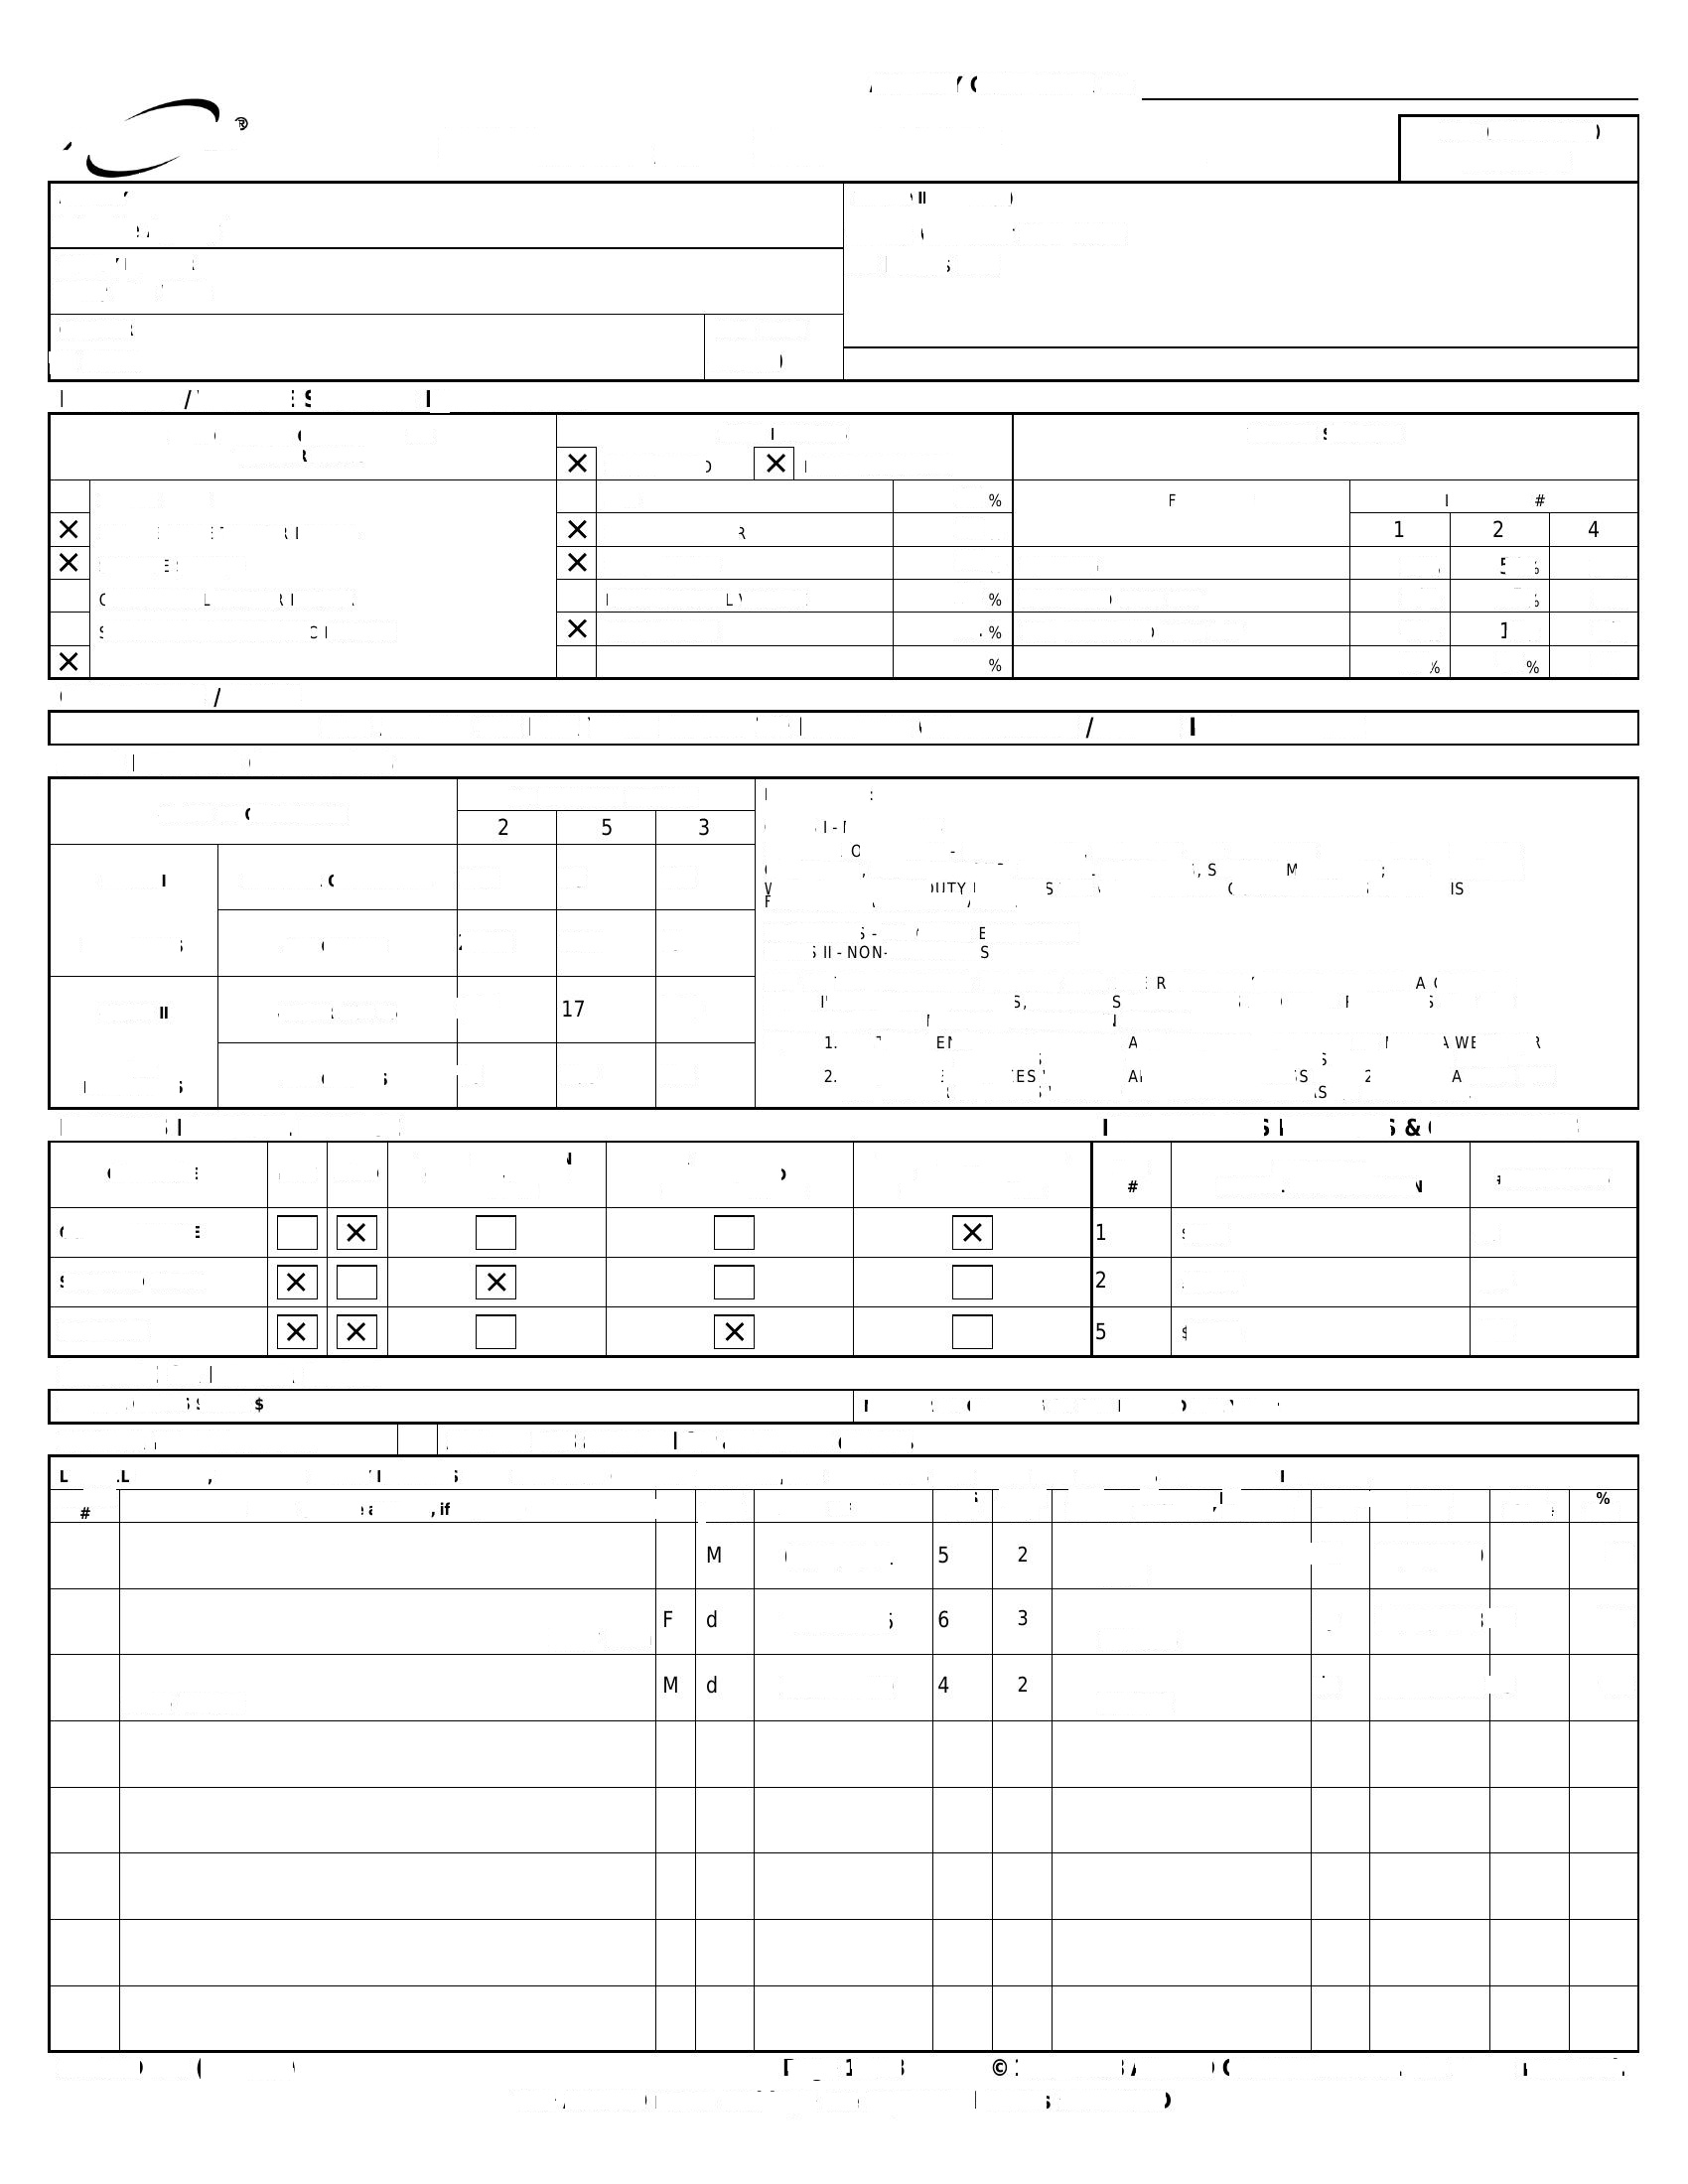

In [77]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display(Image.fromarray(gray))

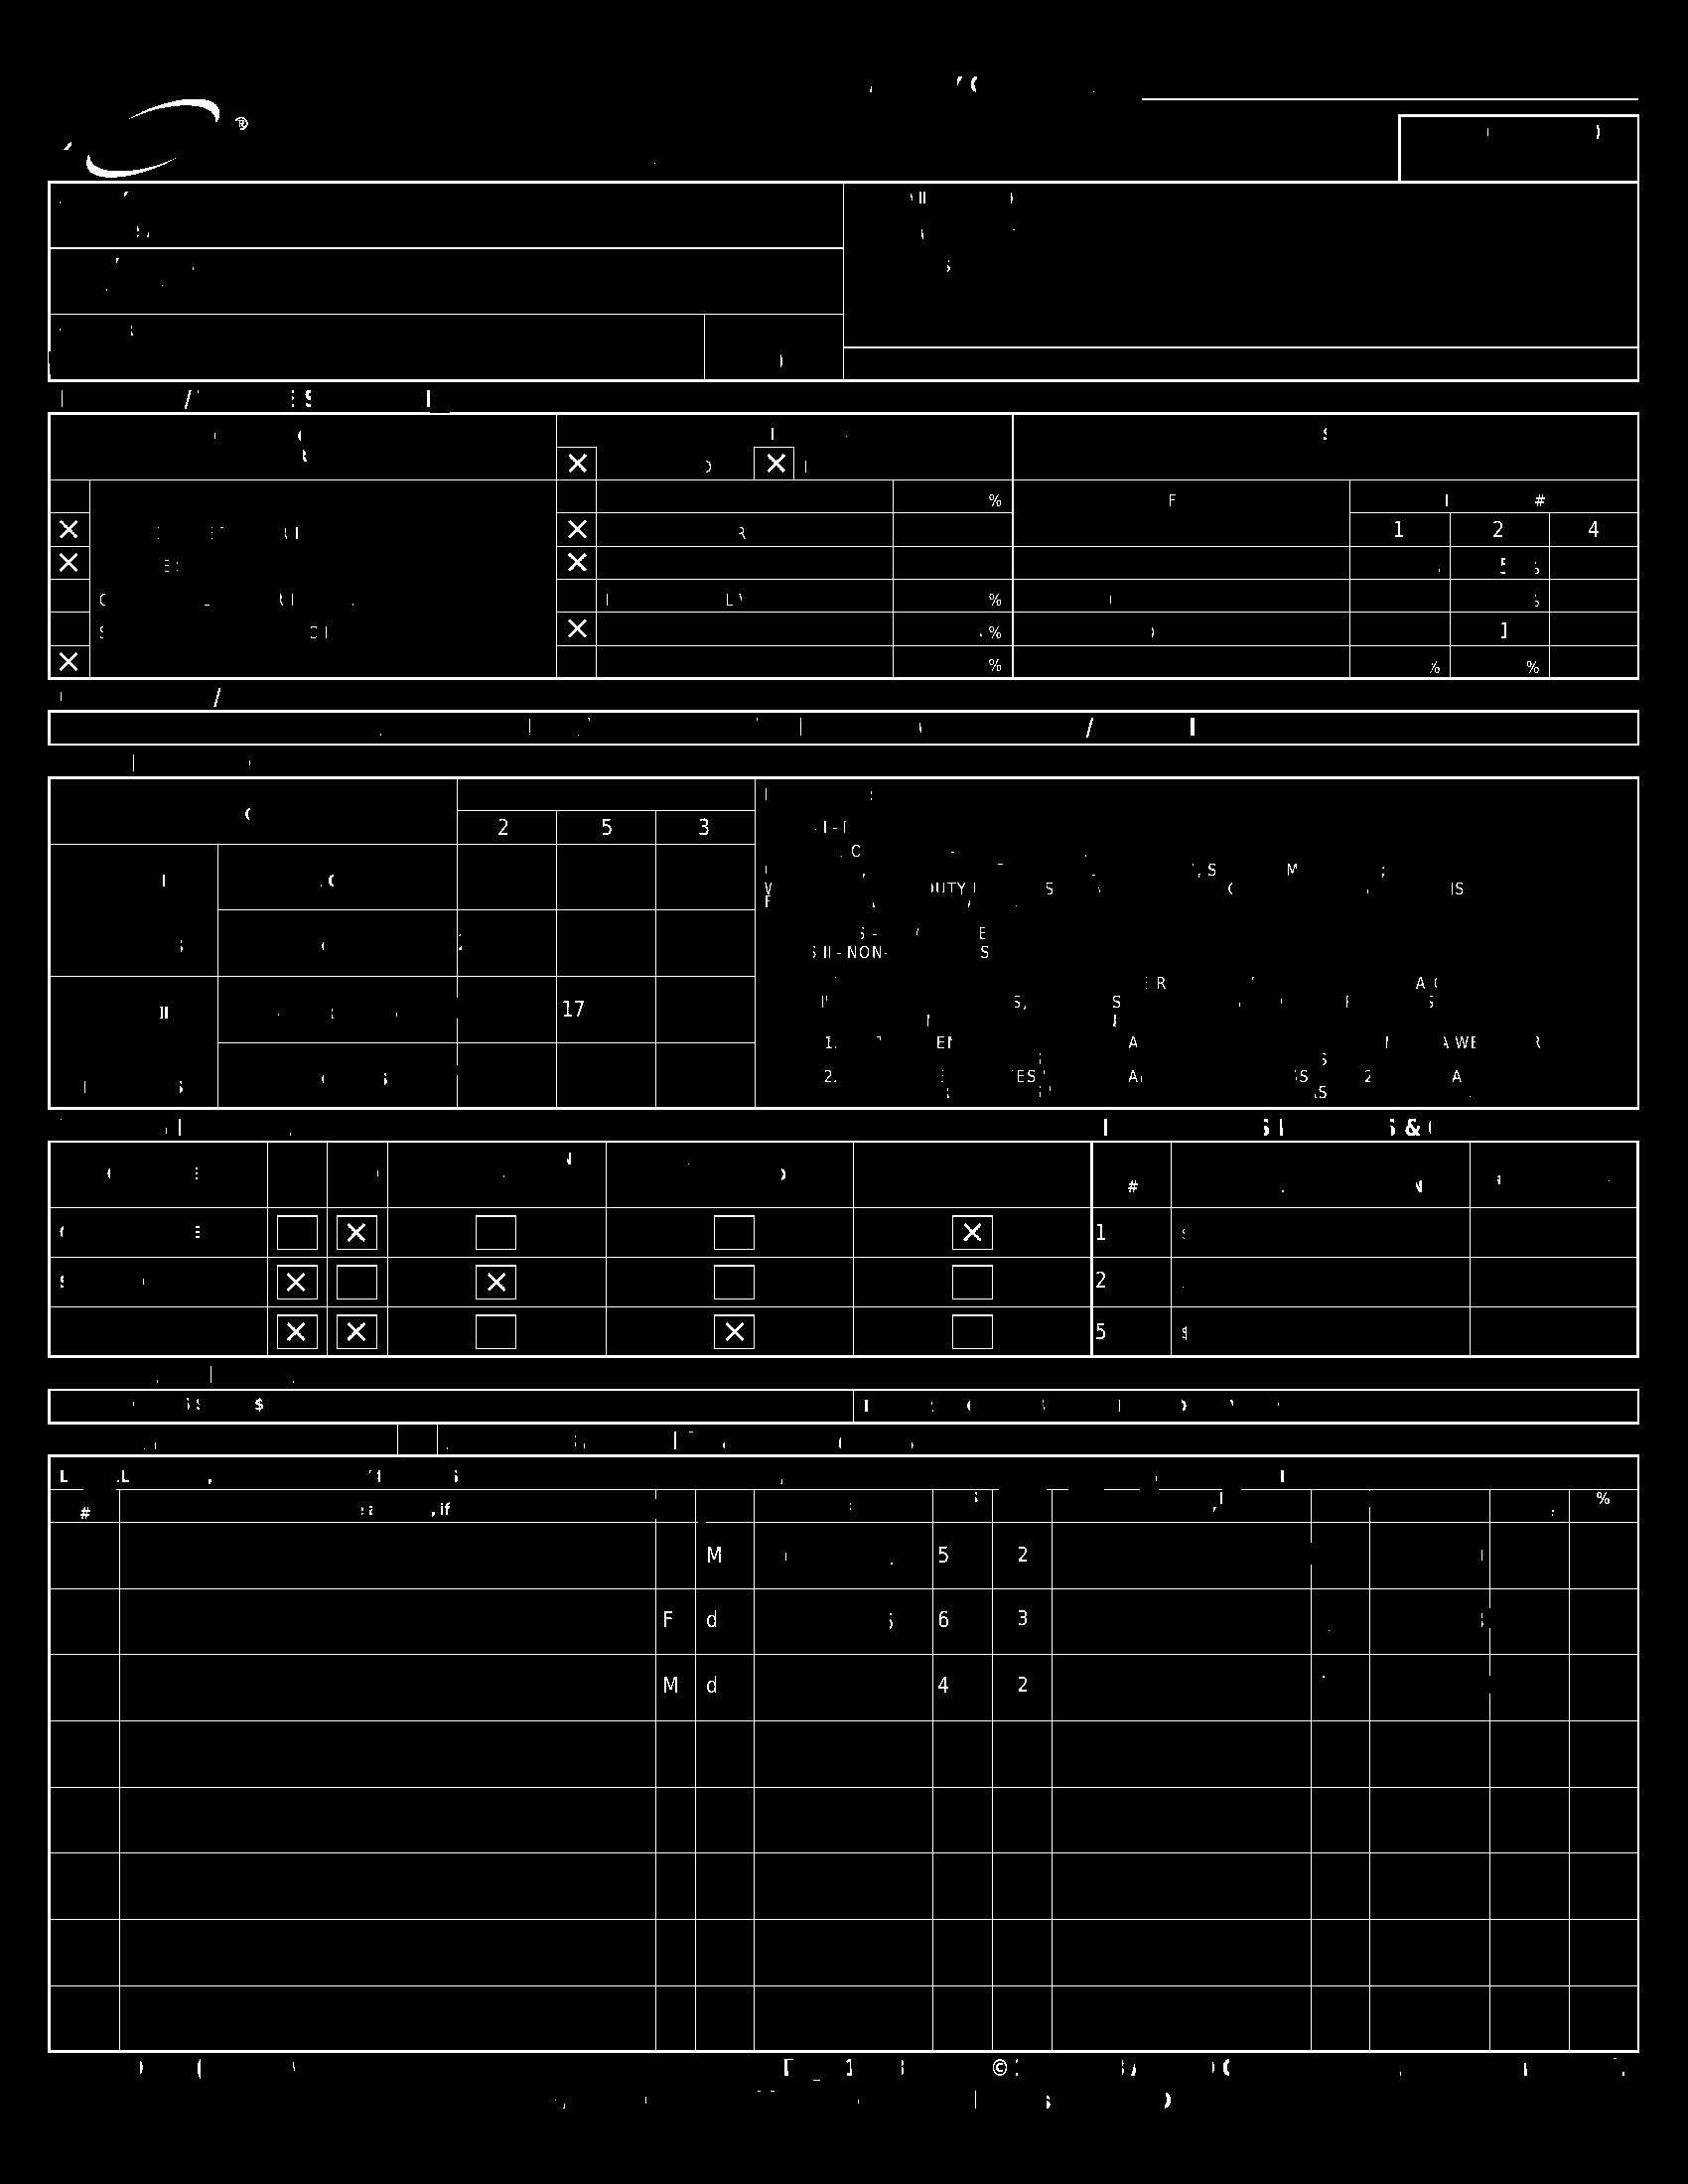

In [5]:
(thresh, img_gray) = cv2.threshold(gray, 128, 255,cv2.THRESH_OTSU)
img_bin = 255-img_gray
display(Image.fromarray(img_bin))

## Trial 1 - sobel x .y

In [ ]:
laplacian = cv2.Laplacian(img_bin,cv2.CV_64F)
sobelx = cv2.Sobel(img_bin,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img_bin,cv2.CV_64F,0,1,ksize=5)

d = Image.fromarray(sobelx)
display(d.convert("L"))

In [ ]:
d = Image.fromarray(sobely)
display(d.convert("L"))

In [ ]:
(thresh, img_bin) = cv2.threshold(sobelx, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
img_bin = 255-img_bin 

In [ ]:
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
print(hori_kernel)
print(verticle_kernel)

In [ ]:
temp_img = cv2.erode(img_bin, hori_kernel, iterations=1)
temp_img2 = cv2.dilate(horizontal_lines_img, hori_kernel, iterations=5)
# morpho close vertical
vertical_lines_img = cv2.erode(img_bin, verticle_kernel, iterations=1)
vertical_lines_img = cv2.dilate(vertical_lines_img, verticle_kernel, iterations=5)

In [ ]:
display(Image.fromarray(vertical_lines_img))

In [ ]:
display(Image.fromarray(horizontal_lines_img))

In [ ]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(vertical_lines_img, alpha, horizontal_lines_img, beta, 0.0)
display((Image.fromarray(img_final_bin)).convert('L'))

In [ ]:
contours, hierarchy = cv2.findContours((Image.fromarray(img_final_bin).convert('L')), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
id= -1
overlay_img = cv2.imread(input_file)
boundRect = [None]*len(contours)
for cnt in contours:
    approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)    
    if len(approx)==4 and cv2.contourArea(cnt) > 100:
#         print(cv2.contourArea(cnt))
        color = (128,35, 125)
        id+=1
#       cv2.drawContours(img,[cnt],0,((id*id)%255,(id*10)%255,255),-1)
        boundRect[id] = cv2.boundingRect(approx)
        cv2.rectangle(overlay_img, (int(boundRect[id][0]), int(boundRect[id][1])),           (int(boundRect[id][0]+boundRect[id][2]), int(boundRect[id][1]+boundRect[id][3])), color, 3) 
        

## Trial 2 - skiimage

In [ ]:
image = img_as_bool(img_bin)
# plt.imshow(image, cmap='gray')

In [ ]:
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
print(hori_kernel)
print(verticle_kernel)

In [ ]:
horizontal_lines_img = cv2.erode(img_bin, hori_kernel, iterations=5)
horizontal_lines_img = cv2.dilate(horizontal_lines_img, hori_kernel, iterations=5)
# morpho close vertical
vertical_lines_img = cv2.erode(img_bin, verticle_kernel, iterations=5)
vertical_lines_img = cv2.dilate(vertical_lines_img, verticle_kernel, iterations=5)

In [ ]:
display(Image.fromarray(vertical_lines_img))

In [ ]:
display(Image.fromarray(horizontal_lines_img))

In [ ]:
image = horizontal_lines_img
out = ndi.distance_transform_edt(~horizontal_lines_img)
out = out < 0.01 * out.max()
out = morphology.skeletonize(out)
out = morphology.binary_dilation(out, morphology.selem.disk(5))
out = segmentation.clear_border(out)
out = out | image
plt_show(out)

horiz_out = out
image = vertical_lines_img
out = ndi.distance_transform_edt(~vertical_lines_img)
out = out < 0.01 * out.max()
out = morphology.skeletonize(out)
out = morphology.binary_dilation(out, morphology.selem.disk(5))
out = segmentation.clear_border(out)
out = out | image
out = horiz_out | out
# plt_show(out)
# plt.imsave('gaps_filled.jpg', out, cmap='gray')


In [40]:
import matplotlib as mpl

def plt_show(img, cmap='gray'):
    
    dpi = mpl.rcParams['figure.dpi']
    height, width = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap)

    plt.show()

## Corner detection techniques

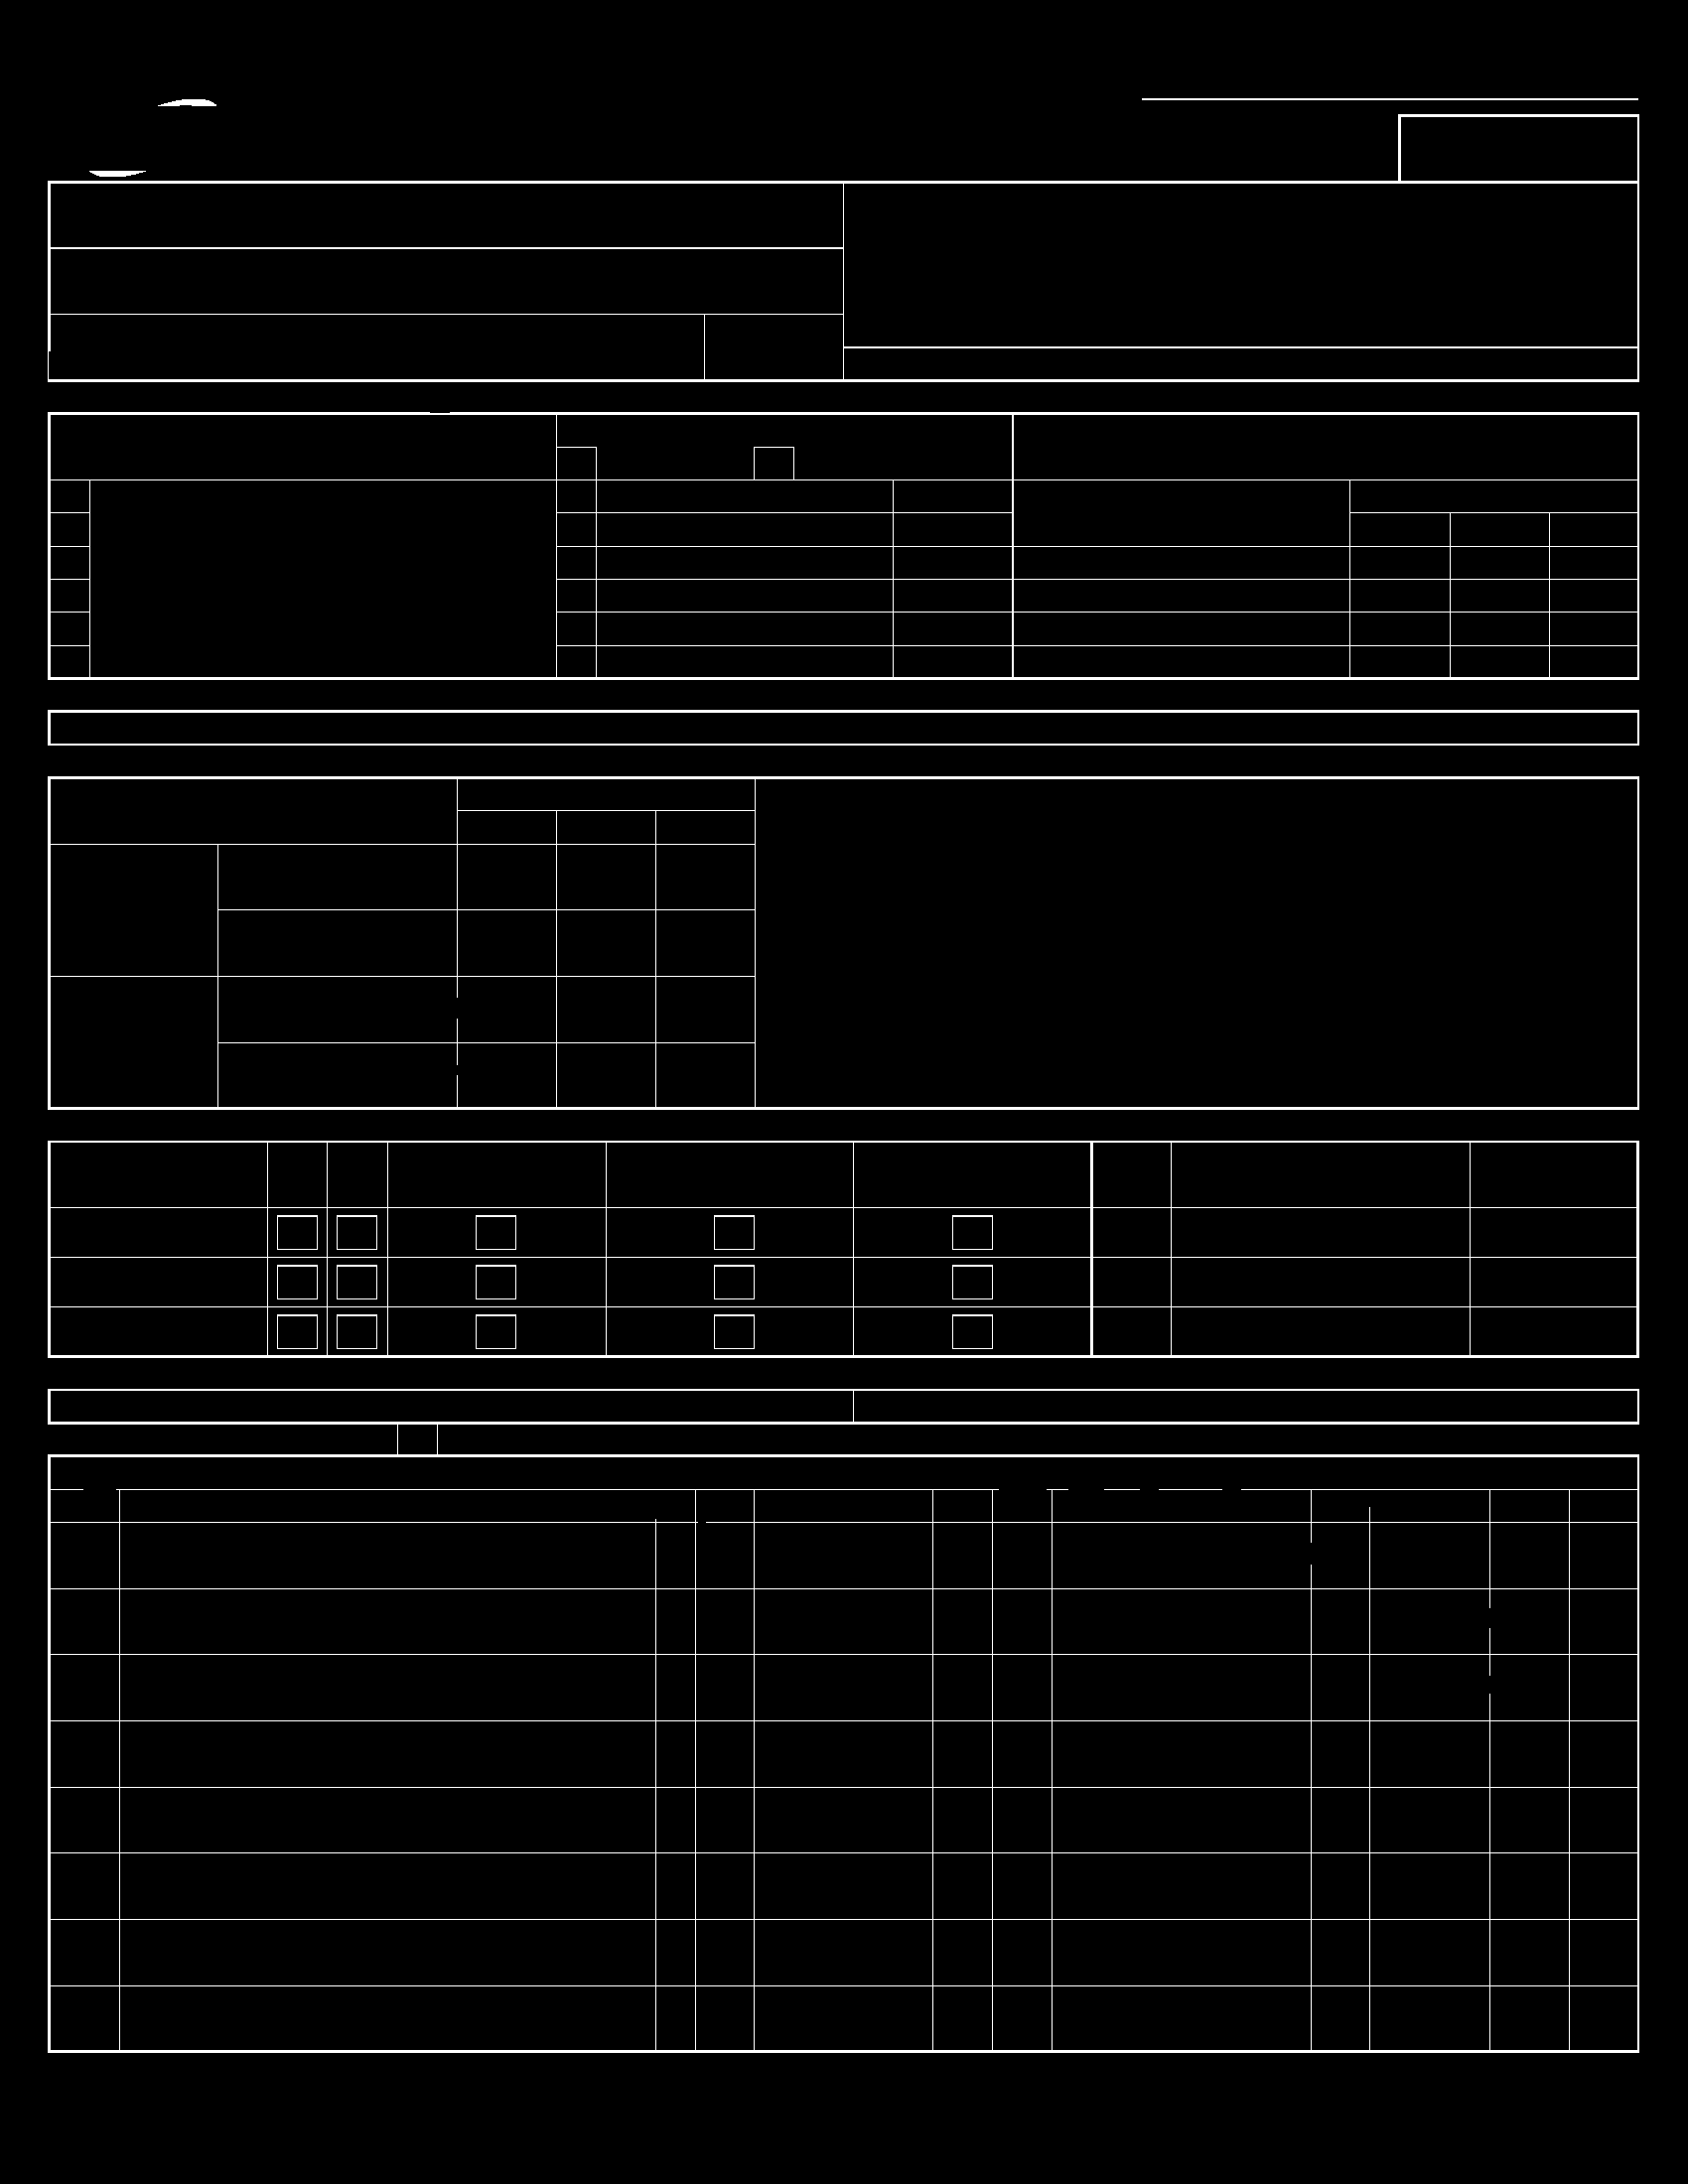

In [6]:
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))

horizontal_lines_img = cv2.erode(img_bin, hori_kernel, iterations=5)
horizontal_lines_img = cv2.dilate(horizontal_lines_img, hori_kernel, iterations=5)
# morpho close vertical
vertical_lines_img = cv2.erode(img_bin, verticle_kernel, iterations=5)
vertical_lines_img = cv2.dilate(vertical_lines_img, verticle_kernel, iterations=5)

img_final_bin = vertical_lines_img | horizontal_lines_img
display((Image.fromarray(img_final_bin)).convert('L'))
# # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
# alpha = 0.5
# beta = 1.0 - alpha
# # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
# img_final_bin = cv2.addWeighted(vertical_lines_img, alpha, horizontal_lines_img, beta, 0.0)
# display((Image.fromarray(com)).convert('L'))

In [17]:
dst = cv2.cornerHarris(img_final_bin,2,3,0.04)


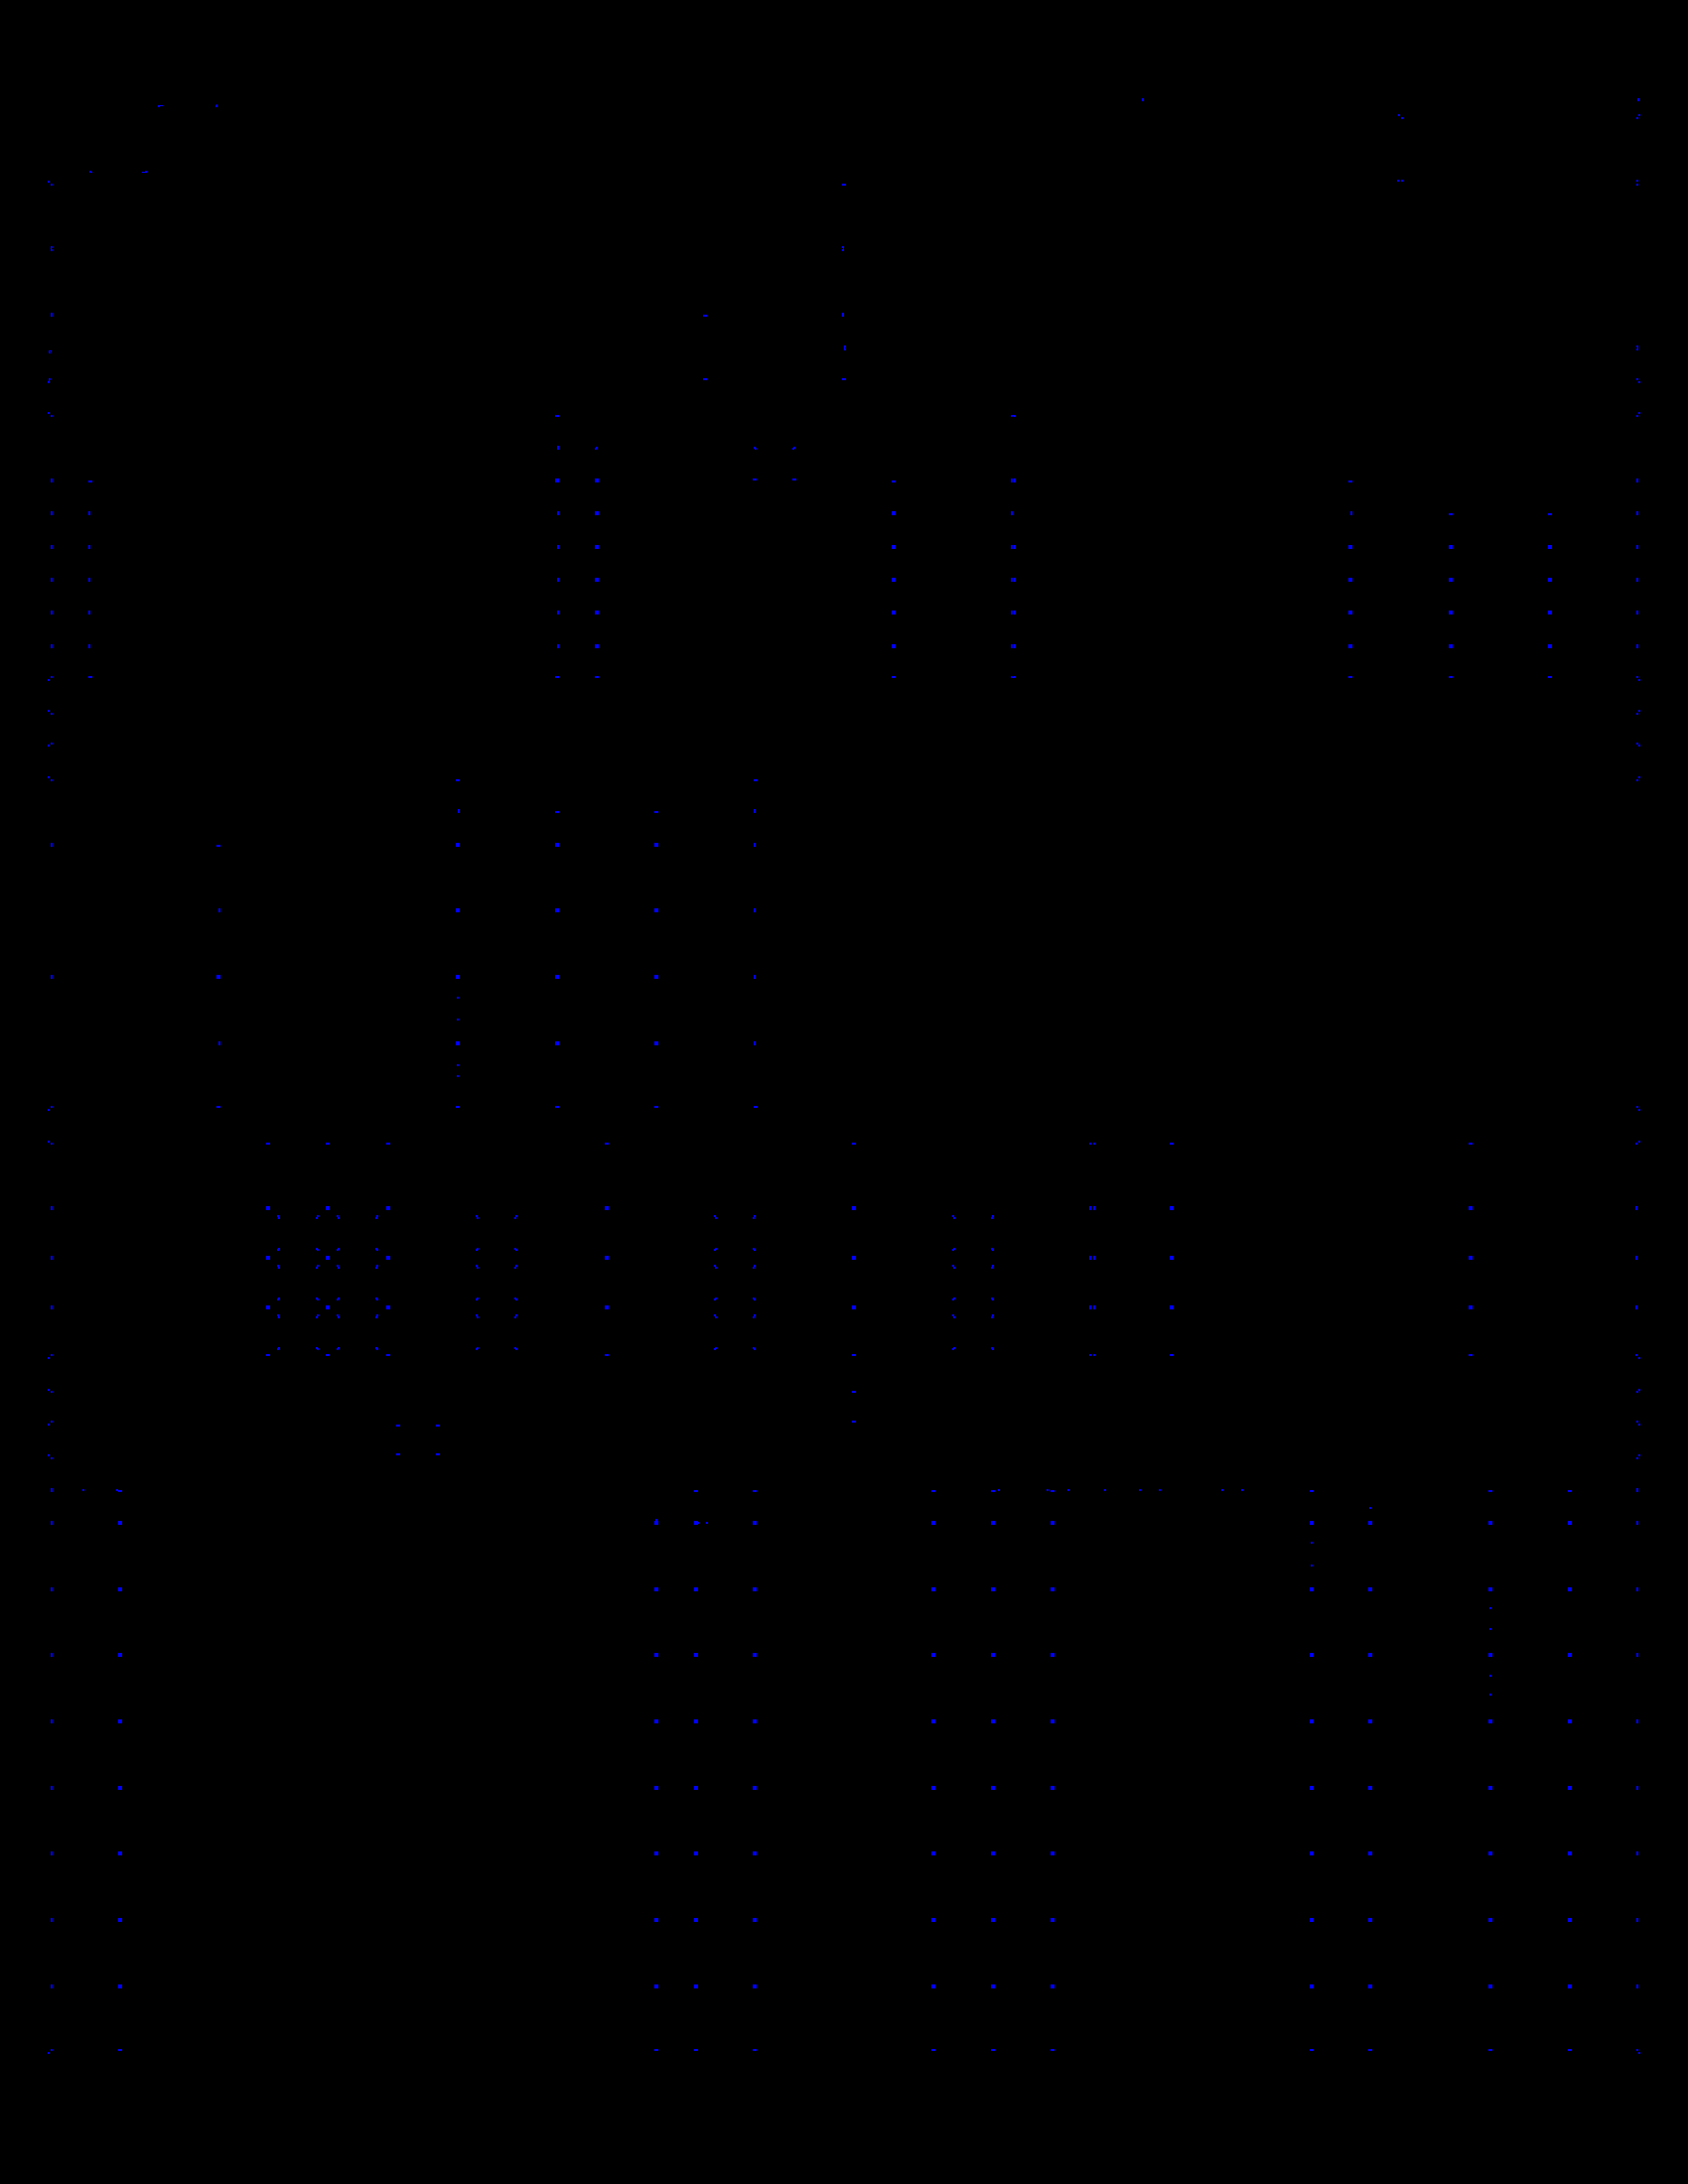

array([[  99, 1150,    2],
       [  99, 1151,    2],
       [  99, 1649,    2],
       ...,
       [2068,   49,    2],
       [2068, 1650,    2],
       [2068, 1651,    2]])

In [18]:
mask = np.zeros_like(img)
mask[dst>0.05*dst.max()]=[0,0,255]
display(Image.fromarray(mask))
coordinates = np.argwhere(mask)
coordinates

In [86]:
coor_list = [l.tolist() for l in list(coordinates)]
coor_tuples = [tuple(l) for l in coor_list]

In [87]:
thresh = 15
import math
def distance(pt1, pt2):
    (x1, y1, z), (x2, y2, z) = pt1, pt2
    dist = math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    return dist

coor_tuples_copy = coor_tuples

i = 1
removed = 0;
for pt1 in coor_tuples:

    print(' I :', i)
    for pt2  in coor_tuples[i::1]:        
        dist = distance(pt1, pt2)
        print(pt1, pt2, dist)
        if (dist > thresh):
            break;
        
        print('cnt = ' +str(i)+ ', Distance :', dist)
        if(dist < thresh):
            removed +=1
            coor_tuples_copy.remove(pt2)      
        
    i+=1

print("Total points original = "+str(len(coor_tuples)))
print("Total points after = "+str(len(coor_tuples_copy)))
print("Total removed = "+str(removed))


 I : 1
(99, 1150, 2) (99, 1151, 2) 1.0
cnt = 1, Distance : 1.0
(99, 1150, 2) (99, 1649, 2) 499.0
 I : 2
(99, 1649, 2) (99, 1650, 2) 1.0
cnt = 2, Distance : 1.0
(99, 1649, 2) (100, 1150, 2) 499.001002003002
 I : 3
(100, 1150, 2) (100, 1151, 2) 1.0
cnt = 3, Distance : 1.0
(100, 1150, 2) (100, 1649, 2) 499.0
 I : 4
(100, 1649, 2) (100, 1650, 2) 1.0
cnt = 4, Distance : 1.0
(100, 1649, 2) (101, 1150, 2) 499.001002003002
 I : 5
(101, 1150, 2) (101, 1151, 2) 1.0
cnt = 5, Distance : 1.0
(101, 1150, 2) (101, 1649, 2) 499.0
 I : 6
(101, 1649, 2) (101, 1650, 2) 1.0
cnt = 6, Distance : 1.0
(101, 1649, 2) (105, 218, 2) 1431.0055904852363
 I : 7
(105, 218, 2) (106, 159, 2) 59.00847396772772
 I : 8
(106, 159, 2) (106, 160, 2) 1.0
cnt = 8, Distance : 1.0
(106, 159, 2) (106, 161, 2) 2.0
cnt = 8, Distance : 2.0
(106, 159, 2) (106, 162, 2) 3.0
cnt = 8, Distance : 3.0
(106, 159, 2) (106, 163, 2) 4.0
cnt = 8, Distance : 4.0
(106, 159, 2) (106, 217, 2) 58.0
 I : 9
(106, 217, 2) (106, 218, 2) 1.0
cnt = 9, Di

cnt = 222, Distance : 1.0
(583, 898, 2) (583, 900, 2) 2.0
cnt = 222, Distance : 2.0
(583, 898, 2) (583, 901, 2) 3.0
cnt = 222, Distance : 3.0
(583, 898, 2) (583, 1018, 2) 120.0
 I : 223
(583, 1018, 2) (583, 1019, 2) 1.0
cnt = 223, Distance : 1.0
(583, 1018, 2) (583, 1021, 2) 3.0
cnt = 223, Distance : 3.0
(583, 1018, 2) (583, 1022, 2) 4.0
cnt = 223, Distance : 4.0
(583, 1018, 2) (583, 1358, 2) 340.0
 I : 224
(583, 1358, 2) (583, 1359, 2) 1.0
cnt = 224, Distance : 1.0
(583, 1358, 2) (583, 1360, 2) 2.0
cnt = 224, Distance : 2.0
(583, 1358, 2) (583, 1361, 2) 3.0
cnt = 224, Distance : 3.0
(583, 1358, 2) (583, 1459, 2) 101.0
 I : 225
(583, 1459, 2) (583, 1460, 2) 1.0
cnt = 225, Distance : 1.0
(583, 1459, 2) (583, 1461, 2) 2.0
cnt = 225, Distance : 2.0
(583, 1459, 2) (583, 1462, 2) 3.0
cnt = 225, Distance : 3.0
(583, 1459, 2) (583, 1559, 2) 100.0
 I : 226
(583, 1559, 2) (583, 1560, 2) 1.0
cnt = 226, Distance : 1.0
(583, 1559, 2) (583, 1561, 2) 2.0
cnt = 226, Distance : 2.0
(583, 1559, 2) (583

 I : 417
(915, 659, 2) (915, 660, 2) 1.0
cnt = 417, Distance : 1.0
(915, 659, 2) (915, 661, 2) 2.0
cnt = 417, Distance : 2.0
(915, 659, 2) (915, 662, 2) 3.0
cnt = 417, Distance : 3.0
(915, 659, 2) (915, 759, 2) 100.0
 I : 418
(915, 759, 2) (915, 760, 2) 1.0
cnt = 418, Distance : 1.0
(915, 759, 2) (916, 220, 2) 539.0009276429865
 I : 419
(916, 220, 2) (916, 221, 2) 1.0
cnt = 419, Distance : 1.0
(916, 220, 2) (916, 459, 2) 239.0
 I : 420
(916, 459, 2) (916, 460, 2) 1.0
cnt = 420, Distance : 1.0
(916, 459, 2) (916, 461, 2) 2.0
cnt = 420, Distance : 2.0
(916, 459, 2) (916, 462, 2) 3.0
cnt = 420, Distance : 3.0
(916, 459, 2) (916, 559, 2) 100.0
 I : 421
(916, 559, 2) (916, 560, 2) 1.0
cnt = 421, Distance : 1.0
(916, 559, 2) (916, 561, 2) 2.0
cnt = 421, Distance : 2.0
(916, 559, 2) (916, 562, 2) 3.0
cnt = 421, Distance : 3.0
(916, 559, 2) (916, 659, 2) 100.0
 I : 422
(916, 659, 2) (916, 660, 2) 1.0
cnt = 422, Distance : 1.0
(916, 659, 2) (916, 661, 2) 2.0
cnt = 422, Distance : 2.0
(916, 659,

 I : 615
(1258, 339, 2) (1258, 340, 2) 1.0
cnt = 615, Distance : 1.0
(1258, 339, 2) (1258, 341, 2) 2.0
cnt = 615, Distance : 2.0
(1258, 339, 2) (1258, 378, 2) 39.0
 I : 616
(1258, 378, 2) (1258, 379, 2) 1.0
cnt = 616, Distance : 1.0
(1258, 378, 2) (1258, 380, 2) 2.0
cnt = 616, Distance : 2.0
(1258, 378, 2) (1258, 479, 2) 101.0
 I : 617
(1258, 479, 2) (1258, 480, 2) 1.0
cnt = 617, Distance : 1.0
(1258, 479, 2) (1258, 481, 2) 2.0
cnt = 617, Distance : 2.0
(1258, 479, 2) (1258, 518, 2) 39.0
 I : 618
(1258, 518, 2) (1258, 519, 2) 1.0
cnt = 618, Distance : 1.0
(1258, 518, 2) (1258, 520, 2) 2.0
cnt = 618, Distance : 2.0
(1258, 518, 2) (1258, 719, 2) 201.0
 I : 619
(1258, 719, 2) (1258, 720, 2) 1.0
cnt = 619, Distance : 1.0
(1258, 719, 2) (1258, 721, 2) 2.0
cnt = 619, Distance : 2.0
(1258, 719, 2) (1258, 758, 2) 39.0
 I : 620
(1258, 758, 2) (1258, 759, 2) 1.0
cnt = 620, Distance : 1.0
(1258, 758, 2) (1258, 760, 2) 2.0
cnt = 620, Distance : 2.0
(1258, 758, 2) (1258, 959, 2) 201.0
 I : 621
(125

cnt = 845, Distance : 1.0
(1359, 339, 2) (1359, 379, 2) 40.0
 I : 846
(1359, 379, 2) (1359, 380, 2) 1.0
cnt = 846, Distance : 1.0
(1359, 379, 2) (1359, 479, 2) 100.0
 I : 847
(1359, 479, 2) (1359, 480, 2) 1.0
cnt = 847, Distance : 1.0
(1359, 479, 2) (1359, 519, 2) 40.0
 I : 848
(1359, 519, 2) (1359, 520, 2) 1.0
cnt = 848, Distance : 1.0
(1359, 519, 2) (1359, 719, 2) 200.0
 I : 849
(1359, 719, 2) (1359, 720, 2) 1.0
cnt = 849, Distance : 1.0
(1359, 719, 2) (1359, 759, 2) 40.0
 I : 850
(1359, 759, 2) (1359, 760, 2) 1.0
cnt = 850, Distance : 1.0
(1359, 759, 2) (1359, 959, 2) 200.0
 I : 851
(1359, 959, 2) (1359, 960, 2) 1.0
cnt = 851, Distance : 1.0
(1359, 959, 2) (1359, 999, 2) 40.0
 I : 852
(1359, 999, 2) (1359, 1000, 2) 1.0
cnt = 852, Distance : 1.0
(1359, 999, 2) (1364, 51, 2) 948.0131855623106
 I : 853
(1364, 51, 2) (1364, 52, 2) 1.0
cnt = 853, Distance : 1.0
(1364, 51, 2) (1364, 268, 2) 217.0
 I : 854
(1364, 268, 2) (1364, 269, 2) 1.0
cnt = 854, Distance : 1.0
(1364, 268, 2) (1364, 27

cnt = 1048, Distance : 3.0
(1601, 1499, 2) (1601, 1579, 2) 80.0
 I : 1049
(1601, 1579, 2) (1601, 1580, 2) 1.0
cnt = 1049, Distance : 1.0
(1601, 1579, 2) (1601, 1581, 2) 2.0
cnt = 1049, Distance : 2.0
(1601, 1579, 2) (1601, 1582, 2) 3.0
cnt = 1049, Distance : 3.0
(1601, 1579, 2) (1601, 1648, 2) 69.0
 I : 1050
(1601, 1648, 2) (1601, 1649, 2) 1.0
cnt = 1050, Distance : 1.0
(1601, 1648, 2) (1602, 51, 2) 1597.0003130870075
 I : 1051
(1602, 51, 2) (1602, 52, 2) 1.0
cnt = 1051, Distance : 1.0
(1602, 51, 2) (1602, 119, 2) 68.0
 I : 1052
(1602, 119, 2) (1602, 120, 2) 1.0
cnt = 1052, Distance : 1.0
(1602, 119, 2) (1602, 121, 2) 2.0
cnt = 1052, Distance : 2.0
(1602, 119, 2) (1602, 122, 2) 3.0
cnt = 1052, Distance : 3.0
(1602, 119, 2) (1602, 659, 2) 540.0
 I : 1053
(1602, 659, 2) (1602, 660, 2) 1.0
cnt = 1053, Distance : 1.0
(1602, 659, 2) (1602, 661, 2) 2.0
cnt = 1053, Distance : 2.0
(1602, 659, 2) (1602, 662, 2) 3.0
cnt = 1053, Distance : 3.0
(1602, 659, 2) (1602, 699, 2) 40.0
 I : 1054
(1602, 6

(1802, 699, 2) (1802, 758, 2) 59.0
 I : 1215
(1802, 758, 2) (1802, 759, 2) 1.0
cnt = 1215, Distance : 1.0
(1802, 758, 2) (1802, 760, 2) 2.0
cnt = 1215, Distance : 2.0
(1802, 758, 2) (1802, 761, 2) 3.0
cnt = 1215, Distance : 3.0
(1802, 758, 2) (1802, 938, 2) 180.0
 I : 1216
(1802, 938, 2) (1802, 939, 2) 1.0
cnt = 1216, Distance : 1.0
(1802, 938, 2) (1802, 940, 2) 2.0
cnt = 1216, Distance : 2.0
(1802, 938, 2) (1802, 941, 2) 3.0
cnt = 1216, Distance : 3.0
(1802, 938, 2) (1802, 998, 2) 60.0
 I : 1217
(1802, 998, 2) (1802, 999, 2) 1.0
cnt = 1217, Distance : 1.0
(1802, 998, 2) (1802, 1000, 2) 2.0
cnt = 1217, Distance : 2.0
(1802, 998, 2) (1802, 1001, 2) 3.0
cnt = 1217, Distance : 3.0
(1802, 998, 2) (1802, 1058, 2) 60.0
 I : 1218
(1802, 1058, 2) (1802, 1059, 2) 1.0
cnt = 1218, Distance : 1.0
(1802, 1058, 2) (1802, 1060, 2) 2.0
cnt = 1218, Distance : 2.0
(1802, 1058, 2) (1802, 1061, 2) 3.0
cnt = 1218, Distance : 3.0
(1802, 1058, 2) (1802, 1319, 2) 261.0
 I : 1219
(1802, 1319, 2) (1802, 1320, 2

(2064, 119, 2) (2064, 659, 2) 540.0
 I : 1382
(2064, 659, 2) (2064, 660, 2) 1.0
cnt = 1382, Distance : 1.0
(2064, 659, 2) (2064, 661, 2) 2.0
cnt = 1382, Distance : 2.0
(2064, 659, 2) (2064, 662, 2) 3.0
cnt = 1382, Distance : 3.0
(2064, 659, 2) (2064, 699, 2) 40.0
 I : 1383
(2064, 699, 2) (2064, 700, 2) 1.0
cnt = 1383, Distance : 1.0
(2064, 699, 2) (2064, 701, 2) 2.0
cnt = 1383, Distance : 2.0
(2064, 699, 2) (2064, 702, 2) 3.0
cnt = 1383, Distance : 3.0
(2064, 699, 2) (2064, 758, 2) 59.0
 I : 1384
(2064, 758, 2) (2064, 759, 2) 1.0
cnt = 1384, Distance : 1.0
(2064, 758, 2) (2064, 760, 2) 2.0
cnt = 1384, Distance : 2.0
(2064, 758, 2) (2064, 761, 2) 3.0
cnt = 1384, Distance : 3.0
(2064, 758, 2) (2064, 938, 2) 180.0
 I : 1385
(2064, 938, 2) (2064, 939, 2) 1.0
cnt = 1385, Distance : 1.0
(2064, 938, 2) (2064, 940, 2) 2.0
cnt = 1385, Distance : 2.0
(2064, 938, 2) (2064, 941, 2) 3.0
cnt = 1385, Distance : 3.0
(2064, 938, 2) (2064, 998, 2) 60.0
 I : 1386
(2064, 998, 2) (2064, 999, 2) 1.0
cnt = 1

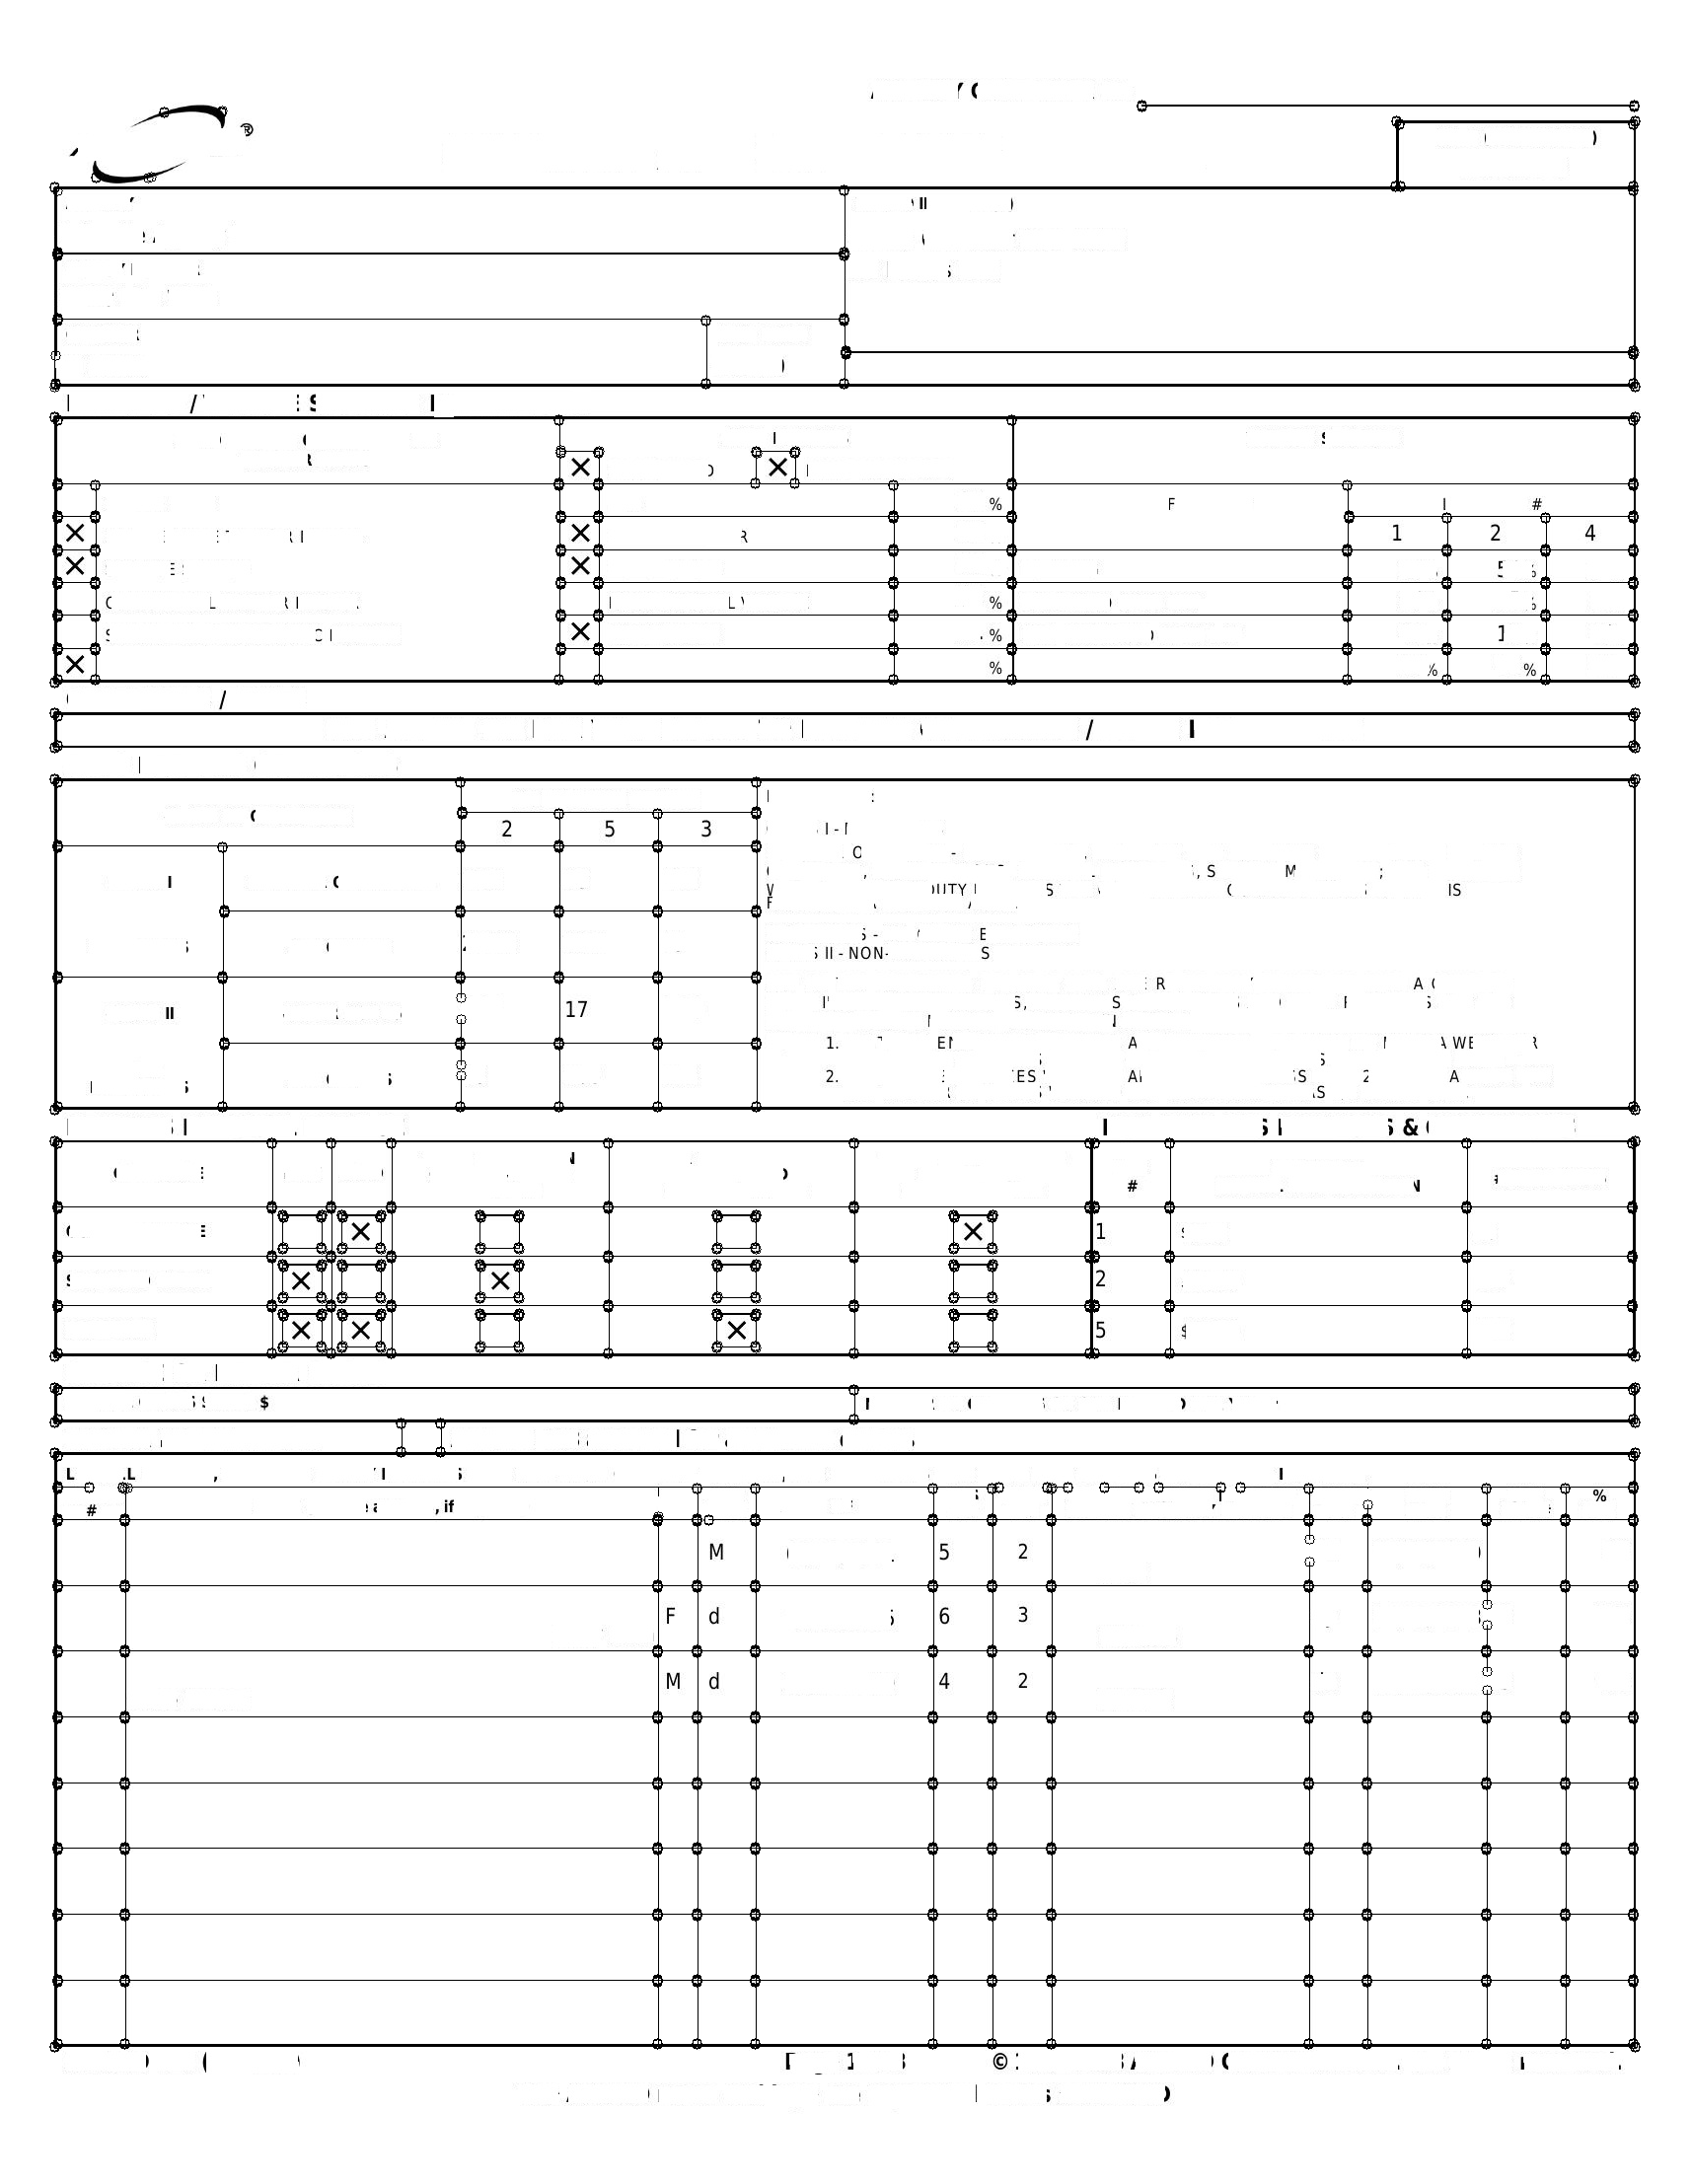

In [88]:
test_img =gray 
for point in [tuple([y,x]) for x,y,_ in coor_tuples_copy]:
        cv2.circle(test_img, point,5, (0,128,128), 0)

plt_show(test_img)

In [41]:
[tuple([x,y]) for x,y,_ in coor_tuples]

[(99, 1150),
 (99, 1649),
 (100, 1150),
 (100, 1649),
 (101, 1150),
 (101, 1649),
 (105, 218),
 (106, 159),
 (106, 162),
 (106, 217),
 (107, 159),
 (107, 217),
 (115, 1408),
 (115, 1650),
 (116, 1408),
 (116, 1650),
 (118, 1411),
 (118, 1648),
 (119, 1411),
 (119, 1648),
 (172, 90),
 (172, 146),
 (173, 90),
 (173, 143),
 (173, 146),
 (181, 1407),
 (181, 1411),
 (181, 1648),
 (182, 48),
 (182, 1407),
 (182, 1411),
 (182, 1648),
 (183, 48),
 (185, 51),
 (185, 848),
 (185, 851),
 (185, 1648),
 (186, 51),
 (186, 848),
 (186, 851),
 (186, 1648),
 (248, 51),
 (248, 848),
 (249, 51),
 (249, 848),
 (250, 51),
 (250, 849),
 (251, 51),
 (251, 848),
 (252, 51),
 (252, 848),
 (315, 51),
 (315, 848),
 (316, 51),
 (316, 848),
 (317, 51),
 (317, 708),
 (317, 711),
 (317, 848),
 (318, 51),
 (318, 708),
 (318, 711),
 (318, 848),
 (348, 850),
 (348, 1648),
 (349, 850),
 (349, 1648),
 (350, 850),
 (350, 1649),
 (351, 850),
 (351, 1648),
 (352, 850),
 (352, 1648),
 (353, 49),
 (381, 49),
 (381, 708),
 (38